In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%cd /content/gdrive/MyDrive/Sentiment140

!ls -la

/content/gdrive/MyDrive/Sentiment140
total 247623
-rw------- 1 root root 238803811 Sep 24 21:45 Sentiment_1.6mil.csv
-rw------- 1 root root    397785 Dec 10 08:29 sentiment_dataset.csv
-rw------- 1 root root    202552 Dec 10 08:28 sentiment_dataset.xlsx
-rw------- 1 root root   6816704 Sep 25 18:55 sentiment-emotion-labelled_Dell_tweets1.csv
-rw------- 1 root root   7344639 Sep 25 16:18 sentiment-emotion-labelled_Dell_tweets.csv


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Data Loading**

In [ ]:
# df = pd.read_csv('/content/gdrive/MyDrive/Dataset/sentiment-emotion-labelled_Dell_tweets.csv')

In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/Sentiment140/sentiment-emotion-labelled_Dell_tweets.csv')
df.head()

,Unnamed: 0,Datetime,Tweet Id,Text,Username,sentiment,sentiment_score,emotion,emotion_score
0,0,2022-09-30 23:29:15+00:00,1575991191170342912,@Logitech @apple @Google @Microsoft @Dell @Len...,ManjuSreedaran,neutral,0.853283,anticipation,0.587121
1,1,2022-09-30 21:46:35+00:00,1575965354425131008,@MK_habit_addict @official_stier @MortalKombat...,MiKeMcDnet,neutral,0.519470,joy,0.886913
2,2,2022-09-30 21:18:02+00:00,1575958171423752203,"As @CRN celebrates its 40th anniversary, Bob F...",jfollett,positive,0.763791,joy,0.960347
3,3,2022-09-30 20:05:24+00:00,1575939891485032450,@dell your customer service is horrible especi...,daveccarr,negative,0.954023,anger,0.983203
4,4,2022-09-30 20:03:17+00:00,1575939359160750080,@zacokalo @Dell @DellCares @Dell give the man ...,heycamella,neutral,0.529170,anger,0.776124


In [ ]:
df.shape

(24970, 9)

In [ ]:
#Selecting only the required columns
df = df[['Text', 'sentiment',]]

#Renaming column 'Text' as 'test'
df.columns = ['text', 'sentiment']

In [ ]:
df.head()

,text,sentiment
0,@Logitech @apple @Google @Microsoft @Dell @Len...,neutral
1,@MK_habit_addict @official_stier @MortalKombat...,neutral
2,"As @CRN celebrates its 40th anniversary, Bob F...",positive
3,@dell your customer service is horrible especi...,negative
4,@zacokalo @Dell @DellCares @Dell give the man ...,neutral


In [ ]:
class_names=['negative','neutral','positive']
N=[0,1,2]
normal_mapping=dict(zip(class_names,N))
reverse_mapping=dict(zip(N,class_names))
df['sentiment']=df['sentiment'].map(normal_mapping)
display(df)

,text,sentiment
0,@Logitech @apple @Google @Microsoft @Dell @Len...,1
1,@MK_habit_addict @official_stier @MortalKombat...,1
2,"As @CRN celebrates its 40th anniversary, Bob F...",2
3,@dell your customer service is horrible especi...,0
4,@zacokalo @Dell @DellCares @Dell give the man ...,1
...,...,...
24965,@ElDarkAngel2 @GamersNexus @Dell I wouldn't ev...,0
24966,@kite_real @GamersNexus @Dell I didn't really ...,2
24967,Hey @JoshTheFixer here it is....27 4K UHD USB-...,1
24968,@bravadogaming @thewolfpena @Alienware @intel ...,1


In [ ]:
# Checking the mapping
print(df['sentiment'].unique())

[1 2 0]


**Visualization**

In [ ]:
display(df['sentiment'].value_counts())

,count
sentiment,
0,10556
2,7366
1,7048


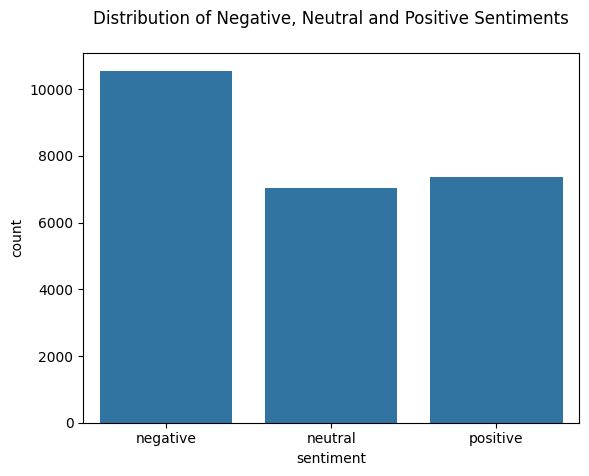

In [ ]:
# Distribution of positive and negative sentiments
ax = sns.countplot(x='sentiment', data=df)
# Get current tick locations and labels
tick_locs = ax.get_xticks()
tick_labels = [reverse_mapping[int(loc)] for loc in tick_locs]

# Set new tick locations and labels
ax.set_xticks(tick_locs)  # Set tick locations explicitly
ax.set_xticklabels(tick_labels)  # Set tick labels
plt.title('Distribution of Negative, Neutral and Positive Sentiments\n')
plt.show()

**Data Pre-Processing**

In [ ]:
# Removing URLs, Mentions and Websites
def remove_url_mention(text):
    # Define regex patterns
    url_pattern = r'https?://\S+|www\.\S+'
    mention_pattern = r'@\w+'
    site_pattern = r'\b\w+\.com\b'

    # Removing URLs, mentions, websites
    text = re.sub(url_pattern, '', text)
    text = re.sub(mention_pattern, '', text)
    text = re.sub(site_pattern, '', text)

    return text.strip()

df['wo_url'] = df['text'].apply(lambda text: remove_url_mention(text))

In [ ]:
# Removing Punctuations
translator = str.maketrans('', '', string.punctuation)

df['wo_punc'] = df['wo_url'].apply(lambda text: text.translate(translator))

In [ ]:
# Removing Stopwords
stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stop_words])

df["wo_stop"] = df["wo_punc"].apply(lambda text: remove_stopwords(text))

In [ ]:
# Lower Casing
df["wo_stop"] = df["wo_stop"].str.lower()

In [ ]:
import nltk
nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer

# Initialising the lemmatizer
lemmatizer = WordNetLemmatizer()

def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

# Applying lemmatization
df["cleaned_text"] = df["wo_stop"].apply(lambda text: lemmatize_words(text))
print(df)

[nltk_data] Downloading package wordnet to /root/nltk_data...


                                                    text  sentiment  \
0      @Logitech @apple @Google @Microsoft @Dell @Len...          1   
1      @MK_habit_addict @official_stier @MortalKombat...          1   
2      As @CRN celebrates its 40th anniversary, Bob F...          2   
3      @dell your customer service is horrible especi...          0   
4      @zacokalo @Dell @DellCares @Dell give the man ...          1   
...                                                  ...        ...   
24965  @ElDarkAngel2 @GamersNexus @Dell I wouldn't ev...          0   
24966  @kite_real @GamersNexus @Dell I didn't really ...          2   
24967  Hey @JoshTheFixer here it is....27 4K UHD USB-...          1   
24968  @bravadogaming @thewolfpena @Alienware @intel ...          1   
24969  @rabia_ejaz @Dell Stopped buying windows lapto...          2   

                                                  wo_url  \
0      #WhatIf QWERTY were modified for programmers s...   
1      She's getting a new 

Changing begins


In [ ]:
# from textblob import TextBlob

# def get_polarity(text):
#     return TextBlob(text).sentiment.polarity

# # Calculate polarity score for each row
# df['polarity'] = df['cleaned_text'].apply(get_polarity)
# display(df.head())


In [ ]:
# Train-Test split
df_sampled = df
X = df_sampled['cleaned_text']
y = df_sampled['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(19976,)
(4994,)


In [ ]:
# Vectorization using TF-IDF
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

vocab_size = len(vectorizer.vocabulary_)
print(f'Vocabulary Size: {vocab_size}')

Vocabulary Size: 24066


**SVM**

In [ ]:
X_train_svm = X_train
X_test_svm = X_test
y_train_svm = y_train
y_test_svm = y_test

vectorizer_svm = TfidfVectorizer()
X_train_vec_svm = vectorizer_svm.fit_transform(X_train_svm)
X_test_vec_svm = vectorizer_svm.transform(X_test_svm)

# Model Training
model2 = SVC(probability=True)
model2.fit(X_train_vec_svm, y_train_svm)

SVC(probability=True)

In [ ]:
# Model evaluation
y_pred_svm = model2.predict(X_test_vec_svm) #Prediction
print(f'Accuracy: {accuracy_score(y_test_svm, y_pred_svm)}')
print(classification_report(y_test_svm, y_pred_svm))

Accuracy: 0.7649179014817782
              precision    recall  f1-score   support

           0       0.80      0.87      0.83      2065
           1       0.67      0.65      0.66      1468
           2       0.80      0.73      0.76      1461

    accuracy                           0.76      4994
   macro avg       0.76      0.75      0.75      4994
weighted avg       0.76      0.76      0.76      4994



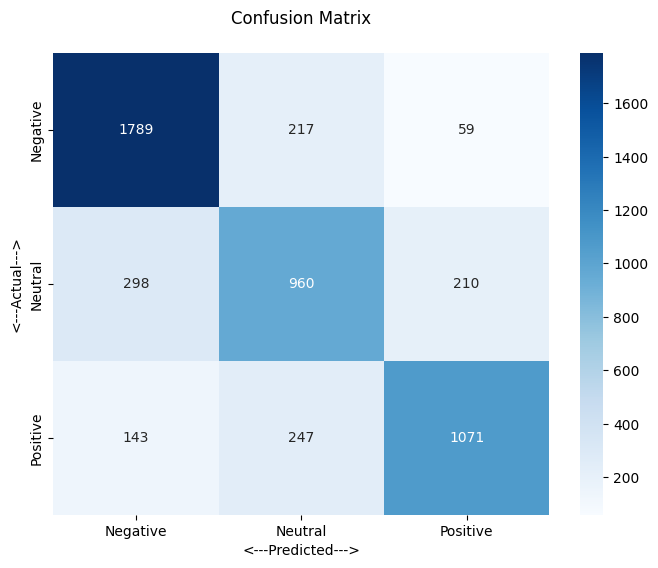

In [ ]:
cm = confusion_matrix(y_test_svm, y_pred_svm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.ylabel('<---Actual--->')
plt.xlabel('<---Predicted--->')
plt.title('Confusion Matrix\n')
plt.show()

In [ ]:
def preprocess_input(text):
    # Applying the same preprocessing as done on training data
    text = text.translate(translator)  # Removing punctuation
    text = remove_stopwords(text)      # Removing stopwords
    text = lemmatize_words(text)       # Applying lemmatization
    return text

def predict_sentiment_with_scores(user_input):
    # Preprocess the user input
    preprocessed_input = preprocess_input(user_input)

    # Vectorize the user input using the already trained vectorizer
    input_vec = vectorizer.transform([preprocessed_input])

    # Predict probabilities using the trained model
    probabilities = model2.predict_proba(input_vec)[0]

    sentiment_scores = {
        'positive': probabilities[2],  # 2 corresponds to 'positive'
        'neutral': probabilities[1],   # 1 corresponds to 'neutral'
        'negative': probabilities[0]   # 0 corresponds to 'negative'
    }

    return sentiment_scores

# Input text
#user_input = "Shubhojit is a smart student"
user_input = input("Please enter a sentence to analyze its sentiment: ")


# Get sentiment scores & Determine which sentiment is the highest
scores = predict_sentiment_with_scores(user_input)
highest_sentiment = max(scores, key=scores.get)

# Print the highest sentiment without score
print(f"The sentiment is: {highest_sentiment.capitalize()}")
print("\nSentiment Scores:")

for sentiment, score in scores.items():
    print(f"{sentiment.capitalize()}: {score:.6f}")


Please enter a sentence to analyze its sentiment: Shubhojit is a smart student
The sentiment is: Positive

Sentiment Scores:
Positive: 0.937322
Neutral: 0.055110
Negative: 0.007568


**Logistic Regression**

In [ ]:
X_train_lr = X_train
X_test_lr = X_test
y_train_lr = y_train
y_test_lr = y_test

vectorizer_lr = TfidfVectorizer()
X_train_vec_lr = vectorizer_lr.fit_transform(X_train_lr)
X_test_vec_lr = vectorizer_lr.transform(X_test_lr)

# Model Training
model4 = LogisticRegression(max_iter=1000)
model4.fit(X_train_vec_lr, y_train_lr)

LogisticRegression(max_iter=1000)

In [ ]:
# Model evaluation
y_pred_lr = model4.predict(X_test_vec_lr) #Prediction
print(f'Accuracy: {accuracy_score(y_test_lr, y_pred_lr)}')
print(classification_report(y_test_lr, y_pred_lr))

Accuracy: 0.7573087705246295
              precision    recall  f1-score   support

           0       0.80      0.86      0.83      2065
           1       0.68      0.62      0.65      1468
           2       0.77      0.75      0.76      1461

    accuracy                           0.76      4994
   macro avg       0.75      0.74      0.74      4994
weighted avg       0.75      0.76      0.75      4994



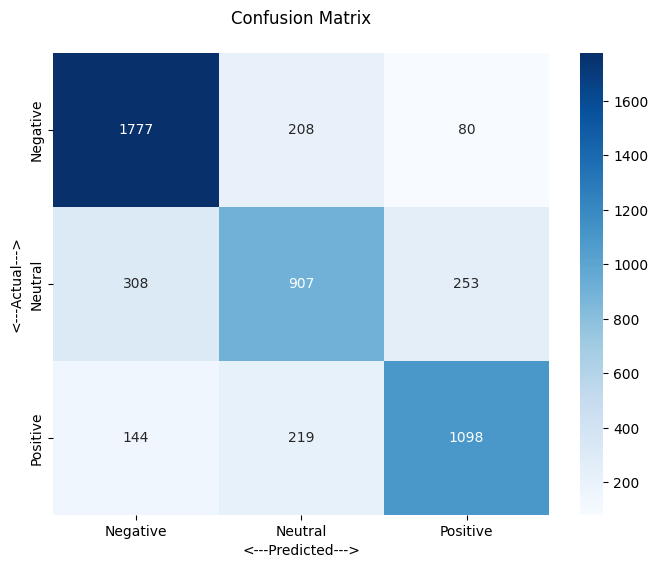

In [ ]:
cm = confusion_matrix(y_test_lr, y_pred_lr)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.ylabel('<---Actual--->')
plt.xlabel('<---Predicted--->')
plt.title('Confusion Matrix\n')
plt.show()

Changing Begins

In [ ]:
# # Create a DataFrame to compare true labels and predictions
# error_analysis_df = pd.DataFrame({
#     'text': X_test_lr,
#     'true_label': y_test_lr,
#     'predicted_label': y_pred_lr
# })

# # Filter for incorrect predictions
# misclassified_df = error_analysis_df[error_analysis_df['true_label'] != error_analysis_df['predicted_label']]
# print(misclassified_df.head())


In [ ]:
# from textblob import TextBlob

# # Calculate polarity scores for X_test_lr
# X_test_lr_polarity = X_test_lr.apply(lambda text: TextBlob(text).sentiment.polarity)

# # Create a DataFrame for polarity and labels
# subcat_df = pd.DataFrame({
#     'text': X_test_lr,
#     'true_label': y_test_lr,
#     'predicted_label': y_pred_lr,
#     'polarity': X_test_lr_polarity
# })

# # Define subcategories
# def assign_subcategory(row):
#     if row['true_label'] == 2:  # Positive
#         if row['polarity'] > 0.7:
#             return "Positive-High"
#         elif row['polarity'] > 0.4:
#             return "Positive-Moderate"
#         else:
#             return "Positive-Low"
#     elif row['true_label'] == 1:  # Neutral
#         if abs(row['polarity']) <= 0.2:
#             return "Neutral-Low"
#         elif abs(row['polarity']) <= 0.4:
#             return "Neutral-Moderate"
#         else:
#             return "Neutral-High"
#     else:  # Negative
#         if row['polarity'] < -0.7:
#             return "Negative-High"
#         elif row['polarity'] < -0.4:
#             return "Negative-Moderate"
#         else:
#             return "Negative-Low"

# subcat_df['subcategory'] = subcat_df.apply(assign_subcategory, axis=1)
# print(subcat_df.head())


In [ ]:
# subcat_df.dropna(subset=['subcategory', 'predicted_label'], inplace=True)
# # Check distribution of true subcategories
# print(subcat_df['subcategory'].value_counts())

# # Check distribution of predicted subcategories
# print(subcat_df['predicted_label'].value_counts())


In [ ]:
# # Add a column for correct predictions
# subcat_df['correct_prediction'] = subcat_df['true_label'] == subcat_df['predicted_label']

# # Plotting the scatter plot
# plt.figure(figsize=(10, 6))
# sns.scatterplot(data=subcat_df, x='polarity', y=subcat_df.index, hue='correct_prediction',
#                 style='correct_prediction', markers={True: 'o', False: 'X'}, palette={True: 'green', False: 'red'}, s=100)

# # Labels and title
# plt.title('Polarity vs Subcategory Prediction (Correct vs Incorrect)')
# plt.xlabel('Polarity Score')
# plt.ylabel('Text Instance (Index)')
# plt.legend(title='Prediction', loc='upper right')
# plt.show()


In [ ]:
# def assign_subcategory(row):
#     if row['true_label'] == 2:  # Positive
#         if row['polarity'] > 0.75:
#             return "Positive-High"
#         elif row['polarity'] > 0.5:
#             return "Positive-Moderate"
#         elif row['polarity'] > 0.3:
#             return "Positive-Low"
#         else:
#             return "Positive-Very Low"  # Optional
#     elif row['true_label'] == 1:  # Neutral
#         if abs(row['polarity']) <= 0.1:
#             return "Neutral-Low"
#         elif abs(row['polarity']) <= 0.3:
#             return "Neutral-Moderate"
#         elif abs(row['polarity']) <= 0.5:
#             return "Neutral-High"
#         else:
#             return "Neutral-Very High"  # Optional
#     else:  # Negative
#         if row['polarity'] < -0.75:
#             return "Negative-High"
#         elif row['polarity'] < -0.5:
#             return "Negative-Moderate"
#         elif row['polarity'] < -0.3:
#             return "Negative-Low"
#         else:
#             return "Negative-Very Low"  # Optional

In [ ]:
# print(subcat_df['subcategory'].unique())  # Check unique values in true labels
# print(subcat_df['predicted_label'].unique())  # Check unique values in predicted labels

In [ ]:
# from sklearn.model_selection import GridSearchCV

# # Define parameter grid
# param_grid = {
#     'C': [0.1, 1, 10],  # Regularization strength
#     'solver': ['lbfgs', 'liblinear'],  # Solver options
#     'max_iter': [500, 1000]
# }

# # Perform grid search
# grid_search = GridSearchCV(LogisticRegression(), param_grid, scoring='accuracy', cv=3)
# grid_search.fit(X_train_vec_lr, y_train_lr)

# print(f"Best Parameters: {grid_search.best_params_}")
# print(f"Best Cross-Validation Accuracy: {grid_search.best_score_}")


Changing Ends

In [ ]:
def preprocess_input(text):
    # Applying the same preprocessing as done on training data
    text = text.translate(translator)  # Removing punctuation
    text = remove_stopwords(text)      # Removing stopwords
    text = lemmatize_words(text)       # Applying lemmatization
    return text

def predict_sentiment_with_scores(user_input):
    # Preprocess the user input
    preprocessed_input = preprocess_input(user_input)

    # Vectorize the user input using the already trained vectorizer
    input_vec = vectorizer.transform([preprocessed_input])

    # Predict probabilities using the trained model
    probabilities = model4.predict_proba(input_vec)[0]

    # Prepare the sentiment scores
    sentiment_scores = {
        'positive': probabilities[2],  # 2 corresponds to 'positive'
        'neutral': probabilities[1],   # 1 corresponds to 'neutral'
        'negative': probabilities[0]   # 0 corresponds to 'negative'
    }

    return sentiment_scores

# Input text
#user_input = "Shubhojit is a smart student"
user_input = input("Please enter a sentence to analyze its sentiment: ")


# Get sentiment scores & determine which sentiment is the highest
scores = predict_sentiment_with_scores(user_input)
highest_sentiment = max(scores, key=scores.get)

# Print the highest sentiment without score
print(f"The sentiment is: {highest_sentiment.capitalize()}")
print("\nSentiment Scores:")

for sentiment, score in scores.items():
    print(f"{sentiment.capitalize()}: {score:.6f}")


Please enter a sentence to analyze its sentiment: there is a constant pain in my head
The sentiment is: Neutral

Sentiment Scores:
Positive: 0.114676
Neutral: 0.534968
Negative: 0.350356


**Ensemble Method(Gradiant Boosting)**

In [ ]:
# # Initialize an empty list to store results
# results = {
#     "SVM_prediction": [],
#     "LR_prediction": [],
#     "True_label": y_test.values
# }

# # Iterate over the test set
# for i in range(X_test_vec.shape[0]):
#     x_sample=X_test_vec[i]
#     # Get predictions from each model and store them
#     svm_pred = y_pred_svm[i]
#     lr_pred = y_pred_lr[i]

#     # Store predictions and the true label
#     results["SVM_prediction"].append(svm_pred)
#     results["LR_prediction"].append(lr_pred)

# # Convert results to a DataFrame for the meta-model training
# meta_dataset = pd.DataFrame(results)

# # Display the meta-dataset structure
# print(meta_dataset.head())

In [ ]:
# # Features: Model predictions
# X_meta = meta_dataset.drop(columns=["True_label"])
# # Labels: Actual sentiment classes
# y_meta = meta_dataset["True_label"]

# # Split into training and testing sets for the meta-model
# X_meta_train, X_meta_test, y_meta_train, y_meta_test = train_test_split(X_meta, y_meta, test_size=0.2, random_state=42)

In [ ]:
# #Gradient Boosting

# from sklearn.ensemble import GradientBoostingClassifier
# from sklearn.metrics import accuracy_score, classification_report

# # Initialize the Gradient Boosting meta-model
# meta_model = GradientBoostingClassifier(random_state=42)

# # Train the meta-model on the stacked predictions
# meta_model.fit(X_meta_train, y_meta_train)

# # Make predictions on the test set for the meta-model
# y_meta_pred = meta_model.predict(X_meta_test)

# # Evaluate the meta-model
# meta_accuracy = accuracy_score(y_meta_test, y_meta_pred)
# print(f"Meta-Model (Gradient Boosting) Accuracy: {meta_accuracy:.4f}")
# print("\nClassification Report:\n", classification_report(y_meta_test, y_meta_pred))

**Deep Learning**

In [ ]:
!pip install keras-preprocessing # Correct package name for installation

from keras_preprocessing.text import Tokenizer  # Import from the correct module in keras-preprocessing
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense,RNN
from keras.layers import SimpleRNN
from sklearn.metrics import accuracy_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.2 MB/s eta 0:00:00


**LSTM**

In [ ]:
# Tokenization and padding for LSTM
max_features = 10000
max_len = 200
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# LSTM Model
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=max_features, output_dim=128, input_length=max_len))
model_lstm.add(LSTM(128))
model_lstm.add(Dense(3, activation='softmax'))  # 3 classes: negative, neutral, positive

# Compile model
model_lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model_lstm.fit(X_train_pad, y_train, epochs=5, batch_size=32, validation_data=(X_test_pad, y_test))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 284s 448ms/step - accuracy: 0.6211 - loss: 0.8016 - val_accuracy: 0.7619 - val_loss: 0.5787
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 355s 500ms/step - accuracy: 0.8348 - loss: 0.4131 - val_accuracy: 0.7621 - val_loss: 0.5958
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 297s 460ms/step - accuracy: 0.8932 - loss: 0.2816 - val_accuracy: 0.7505 - val_loss: 0.7217
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 292s 467ms/step - accuracy: 0.9251 - loss: 0.1994 - val_accuracy: 0.7469 - val_loss: 0.7734
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 305s 440ms/step - accuracy: 0.9481 - loss: 0.1458 - val_accuracy: 0.7381 - val_loss: 0.9511


In [ ]:
# Model evaluation
y_pred_lstm = model_lstm.predict(X_test_pad) #Prediction
y_pred_lstm_classes = np.argmax(y_pred_lstm, axis=1)  # Convert probabilities to class labels

# Accuracy
print(f'Accuracy: {accuracy_score(y_test, y_pred_lstm_classes)}')
print(classification_report(y_test, y_pred_lstm_classes))

157/157 ━━━━━━━━━━━━━━━━━━━━ 21s 133ms/step
Accuracy: 0.7380857028434121
              precision    recall  f1-score   support

           0       0.80      0.83      0.82      2065
           1       0.65      0.62      0.63      1468
           2       0.73      0.73      0.73      1461

    accuracy                           0.74      4994
   macro avg       0.73      0.73      0.73      4994
weighted avg       0.74      0.74      0.74      4994



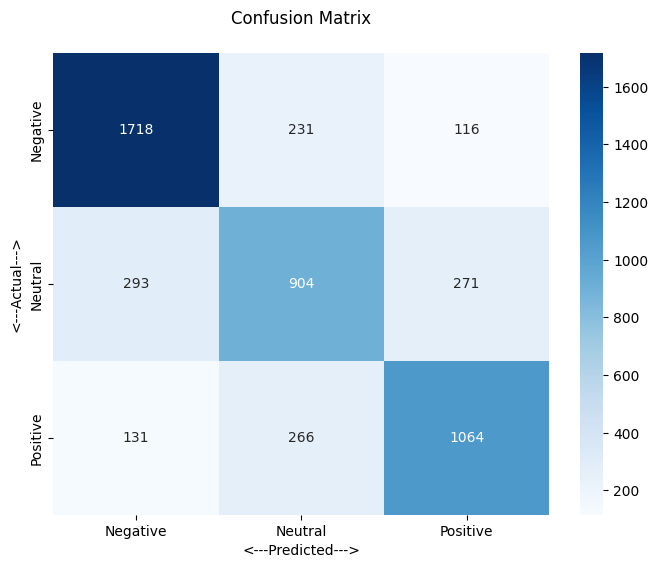

In [ ]:
cm = confusion_matrix(y_test, y_pred_lstm_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.ylabel('<---Actual--->')
plt.xlabel('<---Predicted--->')
plt.title('Confusion Matrix\n')
plt.show()

**RNN**

In [ ]:
# Tokenization and padding for RNN
max_features = 10000  # vocabulary size
max_len = 200

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# RNN Model
model_rnn = Sequential()
model_rnn.add(Embedding(input_dim=max_features, output_dim=128, input_length=max_len))
model_rnn.add(SimpleRNN(128))
model_rnn.add(Dense(3, activation='softmax'))  # 3 classes: negative, neutral, positive

# Compile model
model_rnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model_rnn.fit(X_train_pad, y_train, epochs=5, batch_size=32, validation_data=(X_test_pad, y_test))

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


625/625 ━━━━━━━━━━━━━━━━━━━━ 77s 119ms/step - accuracy: 0.5495 - loss: 0.9085 - val_accuracy: 0.5841 - val_loss: 0.9322
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 72s 115ms/step - accuracy: 0.8166 - loss: 0.4737 - val_accuracy: 0.6804 - val_loss: 0.7964
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 85s 120ms/step - accuracy: 0.9050 - loss: 0.2694 - val_accuracy: 0.7275 - val_loss: 0.8183
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 83s 121ms/step - accuracy: 0.9623 - loss: 0.1164 - val_accuracy: 0.7004 - val_loss: 0.9838
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 80s 118ms/step - accuracy: 0.9192 - loss: 0.2151 - val_accuracy: 0.7185 - val_loss: 0.7436


In [ ]:
# Model evaluation
y_pred_rnn = model_rnn.predict(X_test_pad) #Prediction
y_pred_rnn_classes = np.argmax(y_pred_rnn, axis=1)  # Convert probabilities to class labels

# Accuracy
print(f'Accuracy: {accuracy_score(y_test, y_pred_rnn_classes)}')
print(classification_report(y_test, y_pred_rnn_classes))

157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step
Accuracy: 0.7184621545855026
              precision    recall  f1-score   support

           0       0.83      0.79      0.81      2065
           1       0.63      0.57      0.60      1468
           2       0.66      0.76      0.71      1461

    accuracy                           0.72      4994
   macro avg       0.71      0.71      0.71      4994
weighted avg       0.72      0.72      0.72      4994



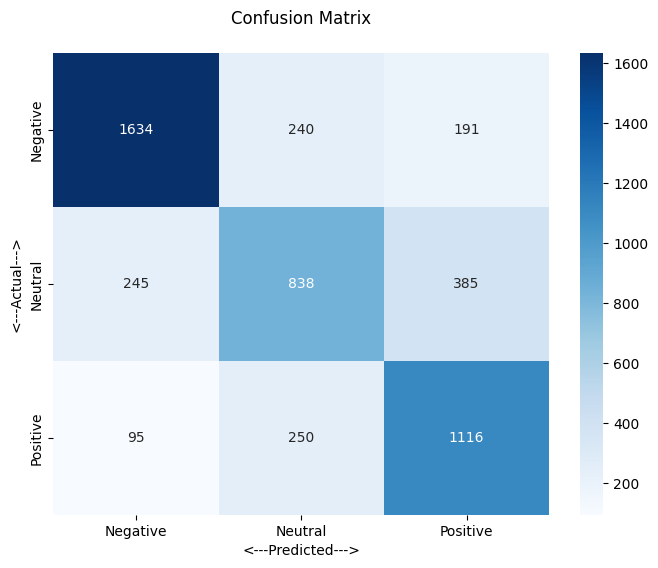

In [ ]:
cm = confusion_matrix(y_test, y_pred_rnn_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.ylabel('<---Actual--->')
plt.xlabel('<---Predicted--->')
plt.title('Confusion Matrix\n')
plt.show()

In [ ]:
import numpy as np

# Sentiment mapping
class_names = ['negative', 'neutral', 'positive']
N = [0, 1, 2]
reverse_mapping = dict(zip(N, class_names))

# Function to preprocess input for LSTM/RNN
def preprocess_input(text, tokenizer, max_len):
    # Tokenize and pad input text
    tokenized_input = tokenizer.texts_to_sequences([text])
    tokenized_input = pad_sequences(tokenized_input, maxlen=max_len)
    return tokenized_input

# Function to preprocess and predict sentiment for LSTM or RNN
def predict_sentiment_for_model(model, tokenizer, text, model_name):
    processed_input = preprocess_input(text, tokenizer, max_len)

    # Get prediction for LSTM or RNN (probabilities for all classes)
    prediction = model.predict(processed_input)

    # Predicted class and sentiment
    predicted_class = np.argmax(prediction, axis=1)[0]
    predicted_sentiment = reverse_mapping[predicted_class]

    # Get sentiment scores for all classes (negative, neutral, positive)
    sentiment_scores = prediction[0]  # Scores for the 3 classes
    negative_score = sentiment_scores[0]
    neutral_score = sentiment_scores[1]
    positive_score = sentiment_scores[2]

    return predicted_sentiment, predicted_class, negative_score, neutral_score, positive_score

# User input for sentiment prediction
user_input = input("Enter a sentence for sentiment analysis: ")

# Assign the existing tokenizer to LSTM and RNN models
tokenizer_lstm = tokenizer
tokenizer_rnn = tokenizer

# Predict sentiment for LSTM model
predicted_sentiment_lstm, predicted_class_lstm, negative_score_lstm, neutral_score_lstm, positive_score_lstm = predict_sentiment_for_model(
    model_lstm, tokenizer_lstm, user_input, 'LSTM')

print(f"\nLSTM Model Prediction: {predicted_sentiment_lstm}")
print(f"LSTM Negative Score: {negative_score_lstm}")
print(f"LSTM Neutral Score: {neutral_score_lstm}")
print(f"LSTM Positive Score: {positive_score_lstm}")

# Predict sentiment for RNN model
predicted_sentiment_rnn, predicted_class_rnn, negative_score_rnn, neutral_score_rnn, positive_score_rnn = predict_sentiment_for_model(
    model_rnn, tokenizer_rnn, user_input, 'RNN')

print(f"\nRNN Model Prediction: {predicted_sentiment_rnn}")
print(f"RNN Negative Score: {negative_score_rnn}")
print(f"RNN Neutral Score: {neutral_score_rnn}")
print(f"RNN Positive Score: {positive_score_rnn}")


Enter a sentence for sentiment analysis: it was painful
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step

LSTM Model Prediction: negative
LSTM Negative Score: 0.8456095457077026
LSTM Neutral Score: 0.10635856539011002
LSTM Positive Score: 0.048031896352767944
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

RNN Model Prediction: negative
RNN Negative Score: 0.8606352210044861
RNN Neutral Score: 0.023639384657144547
RNN Positive Score: 0.11572539806365967


**Ensemble Method**

In [ ]:
#Gradient Boosting

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report

# Convert the probabilities from LSTM and RNN to class labels
y_pred_lstm_classes = np.argmax(y_pred_lstm, axis=1)
y_pred_rnn_classes = np.argmax(y_pred_rnn, axis=1)

# Combine predictions into a single array for the meta-model
X_meta = np.column_stack((
    y_pred_svm,
    y_pred_lr,
    y_pred_lstm_classes,
    y_pred_rnn_classes
))

# Convert y_test to a numpy array if needed
y_test = np.array(y_test)

# Split the meta-data into training and testing sets
X_meta_train, X_meta_test, y_meta_train, y_meta_test = train_test_split(
    X_meta, y_test, test_size=0.2, random_state=42
)

# Initialize the Gradient Boosting meta-model
meta_model = GradientBoostingClassifier(random_state=42)

# Train the meta-model on the stacked predictions
meta_model.fit(X_meta_train, y_meta_train)

# Make predictions on the test set for the meta-model
y_meta_pred = meta_model.predict(X_meta_test)

# Evaluate the meta-model
meta_accuracy = accuracy_score(y_meta_test, y_meta_pred)
print(f"Meta-Model (Gradient Boosting) Accuracy: {meta_accuracy:.4f}")
print("\nClassification Report:\n", classification_report(y_meta_test, y_meta_pred))

Meta-Model (Gradient Boosting) Accuracy: 0.7768

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.88      0.85       450
           1       0.69      0.65      0.67       304
           2       0.78      0.76      0.77       245

    accuracy                           0.78       999
   macro avg       0.77      0.76      0.76       999
weighted avg       0.77      0.78      0.77       999



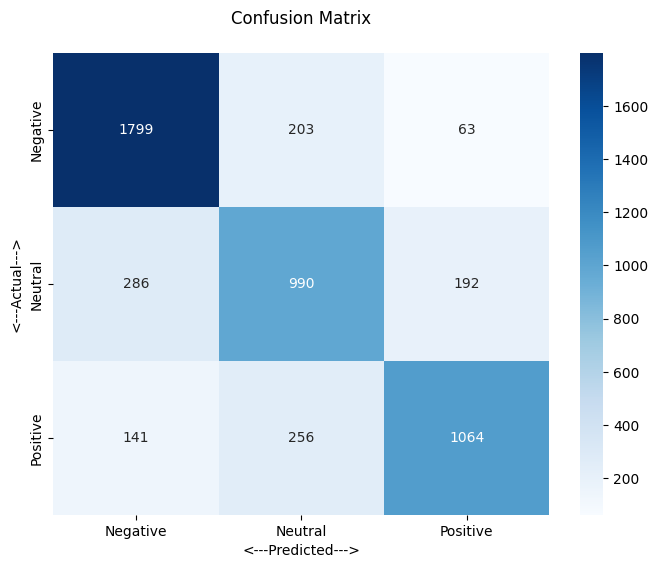

In [ ]:
y_meta_pred_full = meta_model.predict(X_meta)
cm = confusion_matrix(y_test, y_meta_pred_full)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.ylabel('<---Actual--->')
plt.xlabel('<---Predicted--->')
plt.title('Confusion Matrix\n')
plt.show()

In [ ]:
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier

# Sentiment mapping
class_names = ['negative', 'neutral', 'positive']
N = [0, 1, 2]
reverse_mapping = dict(zip(N, class_names))

# Assign the existing tokenizer to LSTM and RNN models
tokenizer_lstm = tokenizer
tokenizer_rnn = tokenizer

# Function to preprocess input for LSTM/RNN
def preprocess_input_for_model(text, tokenizer, max_len):
    tokenized_input = tokenizer.texts_to_sequences([text])
    tokenized_input = pad_sequences(tokenized_input, maxlen=max_len)
    return tokenized_input

# Predict sentiment for LSTM or RNN model and return probabilities
def predict_sentiment_for_model(model, tokenizer, text, max_len):
    processed_input = preprocess_input_for_model(text, tokenizer, max_len)
    prediction = model.predict(processed_input)  # Get probability for each class
    return prediction[0]  # Returns probabilities for negative, neutral, positive

# Function to preprocess user input for traditional models
def preprocess_input(text):
    text = text.translate(translator)  # Removing punctuation
    text = remove_stopwords(text)      # Removing stopwords
    text = lemmatize_words(text)       # Applying lemmatization
    return text

# Combined function to predict sentiment using ensemble
def predict_sentiment_with_scores(user_input):
    # Preprocess user input for LSTM and RNN
    input_for_lstm = preprocess_input_for_model(user_input, tokenizer_lstm, max_len)
    input_for_rnn = preprocess_input_for_model(user_input, tokenizer_rnn, max_len)

    # Get sentiment scores from deep learning models
    lstm_pred = model_lstm.predict(input_for_lstm)[0]
    rnn_pred = model_rnn.predict(input_for_rnn)[0]

    # Get predicted classes for LSTM and RNN
    lstm_class = np.argmax(lstm_pred)
    rnn_class = np.argmax(rnn_pred)

    # Preprocess user input for traditional models
    preprocessed_input = preprocess_input(user_input)

    # Vectorize the user input using the already trained vectorizer
    input_vec = vectorizer.transform([preprocessed_input])

    # Get predictions from traditional models
    svm_pred = model2.predict(input_vec)[0]  # SVM
    lr_pred = model4.predict(input_vec)[0]  # Logistic Regression

    # Stack predicted classes from all models as input for meta-model
    meta_input = np.array([[lstm_class, rnn_class, svm_pred, lr_pred]])

    # Predict final sentiment with the meta-model (Gradient Boosting)
    final_prediction = meta_model.predict(meta_input)[0]

    # Get the probability scores for the final prediction
    probabilities = meta_model.predict_proba(meta_input)[0]
    sentiment_score = {
        'positive': probabilities[2],  # Index for positive
        'neutral': probabilities[1],   # Index for neutral
        'negative': probabilities[0]    # Index for negative
    }

    # Map the prediction to sentiment
    final_sentiment = reverse_mapping[final_prediction]

    return final_sentiment, sentiment_score

# User input
user_input = input("Please enter a sentence to analyze its sentiment: ")

# Get the overall sentiment and sentiment score from the ensemble method
final_sentiment, sentiment_score = predict_sentiment_with_scores(user_input)

# Output the overall sentiment
print(f"The overall sentiment is: {final_sentiment.capitalize()}")

# Output the sentiment scores from the ensemble method
print("\nSentiment Scores from Ensemble Method:")
for sentiment, score in sentiment_score.items():
    print(f"{sentiment.capitalize()}: {score:.6f}")

Please enter a sentence to analyze its sentiment: I was left with pain
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
The overall sentiment is: Negative

Sentiment Scores from Ensemble Method:
Positive: 0.073773
Neutral: 0.259219
Negative: 0.667008


In [ ]:
import joblib

joblib.dump(meta_model, 'ensemble_model.pkl')  # Save as 'ensemble_model.pkl'

['ensemble_model.pkl']

In [ ]:
from google.colab import files
files.download('ensemble_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>